In [61]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from tvb_inversion.base.observation_models import linear
from tvb_inversion.pymc3.prior import Pymc3Prior
from tvb_inversion.pymc3.stats_model import Pymc3Model
from tvb_inversion.pymc3.inference import EstimatorPYMC
from tvb_inversion.pymc3.stats_model_builder import StochasticPymc3ModelBuilder
from tvb_inversion.pymc3.plot import plot_posterior_samples

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#conn = connectivity.Connectivity.from_file()
conn = connectivity.Connectivity()
conn.weights = np.array([[0., 2.], [2., 0.]])
conn.region_labels = np.array(["R1", "R2"])
conn.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
conn.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
conn.configure()

sim = simulator.Simulator(
    model=models.oscillator.Generic2dOscillator(a=np.array([1.5])),
    connectivity=conn,
    coupling=coupling.Difference(),
    integrator=integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(
            nsig=np.array([1e-4]),
            noise_seed=42
        )
    ),
    monitors=[monitors.Raw()],
    simulation_length = 250
)

In [ ]:
sim.configure()

In [ ]:
sim.initial_conditions = np.zeros((conn.horizon, sim.model.nvar, conn.number_of_regions, 1))

In [5]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 98d3d70b-57e8-4e7b-bdbe-8e6ba9993191
coupling,Difference gid: d1550336-df46-4758-8099-8c1e7eb6784a
gid,UUID('ad567683-484e-4ef8-b079-772a5999ea97')
"initial_conditions [min, median, max]","[0, 0, 0]"
initial_conditions dtype,float64
initial_conditions shape,"(2, 2, 2, 1)"
integrator,HeunStochastic gid: 5e6dd176-96c7-4cc4-9544-ea8383a3ab9d
model,Generic2dOscillator gid: cb3eed38-6d89-475a-a19d-e6ed7de4d7db


In [6]:
(t, X), = sim.run()

In [7]:
X.shape

(250, 2, 2, 1)

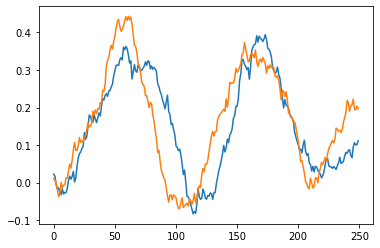

In [8]:
plt.plot(X[:, 0, :, 0]);

In [16]:
def_std = 0.1

model = pm.Model()
with model:
    a_model_star = pm.Normal(name="a_model_star", mu=0.0, sd=1.0, shape=sim.model.a.shape)
    a_model = pm.Deterministic(name="a_model", var=sim.model.a + def_std * a_model_star)
    
    a_coupling_star = pm.Normal(name="a_coupling_star", mu=0.0, sd=1.0)
    a_coupling = pm.Deterministic(name="a_coupling", 
                                  var=sim.coupling.a[0].item() + def_std * a_coupling_star)
    
    x_init_star = pm.Normal(name="x_init_star", mu=0.0, sd=1.0, 
                            shape=sim.initial_conditions.shape[:-1])
    x_init = pm.Deterministic(name="x_init", 
                              var=sim.initial_conditions[:, :, :, 0] + def_std*x_init_star)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    nsig_star = BoundedNormal(name="nsig_star", mu=0.0, sd=1.0)
    nsig = pm.Deterministic("nsig", var=def_std * sim.integrator.noise.nsig[0].item() * nsig_star)
    
    dWt_star = pm.Normal(name="dWt_star", mu=0.0, sd=1.0, shape=X.shape[:-1])
    
    amplitude_star = pm.Normal(name="amplitude_star", mu=0.0, sd=1.0)
    amplitude = pm.Deterministic(name="amplitude", var=1.0 + def_std * amplitude_star)

    offset_star = pm.Normal(name="offset_star", mu=0.0, sd=1.0)
    offset = pm.Deterministic(name="offset", var=def_std * offset_star)
    
    observation_noise_star = pm.HalfNormal("observation_noise_star", sd=1.0)
    observation_noise = pm.Deterministic("observation_noise", var=def_std*observation_noise_star)
    

In [17]:
prior = Pymc3Prior(
    model=model,
    names=["model.a", "coupling.a", "x_init", "integrator.noise.nsig", "dWt_star", 
           "observation.model.amplitude", "observation.model.offset", "observation.noise"], 
    dist=[a_model, a_coupling, x_init, nsig, dWt_star, 
          amplitude, offset, observation_noise]
)

In [18]:
model_builder = StochasticPymc3ModelBuilder(sim=sim, params=prior, 
                                            observation_fun=linear, observation=X[:, :, :, 0])


In [19]:
# model_builder.params.get_observation_model_params()

In [20]:
model_builder.compose_model()

In [21]:
pymc_model = model_builder.build()

In [22]:
pymc_model.model

In [23]:
pymc_estimator = EstimatorPYMC(stats_model=pymc_model)

In [24]:
draws = 500
tune = 500
cores = 2

In [25]:
inference_data = pymc_estimator.run_inference(draws, tune, cores, target_accept=0.9)

/Users/dionperd/Software/TVB/tvb-inversion/tvb_inversion/pymc3/inference.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=draws, tune=tune, cores=cores, target_accept=target_accept)
Auto-assigning NUTS sampler...


06-12-2022 05:06:51 - INFO - pymc3 - Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


06-12-2022 05:06:51 - INFO - pymc3 - Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


06-12-2022 05:07:46 - INFO - pymc3 - Multiprocess sampling (2 chains in 2 jobs)


NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, a_coupling_star, a_model_star]


06-12-2022 05:07:46 - INFO - pymc3 - NUTS: [observation_noise_star, offset_star, amplitude_star, dWt_star, nsig_star, x_init_star, a_coupling_star, a_model_star]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 27113 seconds.


07-12-2022 12:39:42 - INFO - pymc3 - Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 27113 seconds.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


07-12-2022 12:39:52 - WARNING - pymc3 - The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


07-12-2022 12:39:52 - WARNING - pymc3 - The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


07-12-2022 12:39:52 - INFO - pymc3 - The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


The estimated number of effective samples is smaller than 200 for some parameters.


07-12-2022 12:39:52 - ERROR - pymc3 - The estimated number of effective samples is smaller than 200 for some parameters.


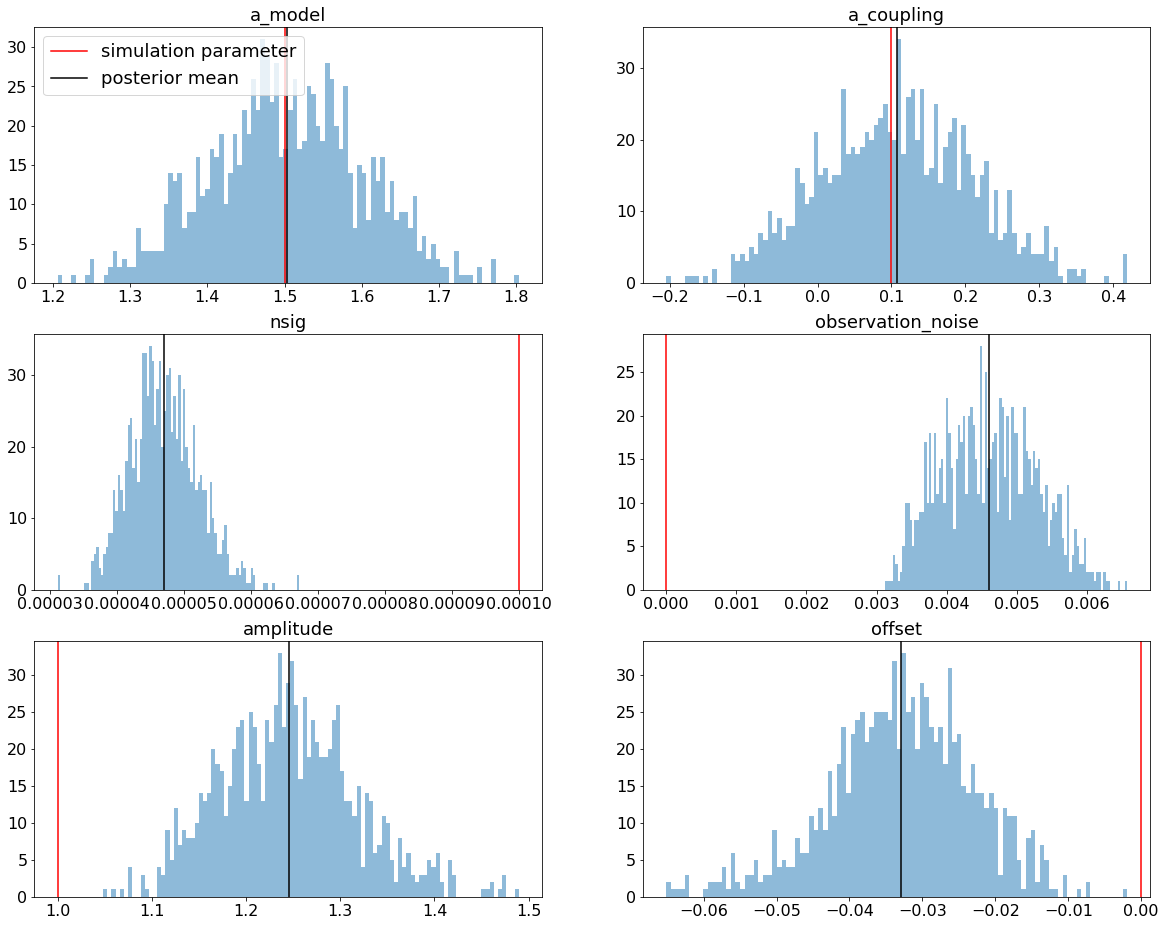

In [64]:
init_params = {
    "a_model": sim.model.a[0],
    "a_coupling": sim.coupling.a[0],
    "nsig": sim.integrator.noise.nsig[0],
    "observation_noise": 0.0,
    "amplitude": 1.0,
    "offset": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data,  init_params)

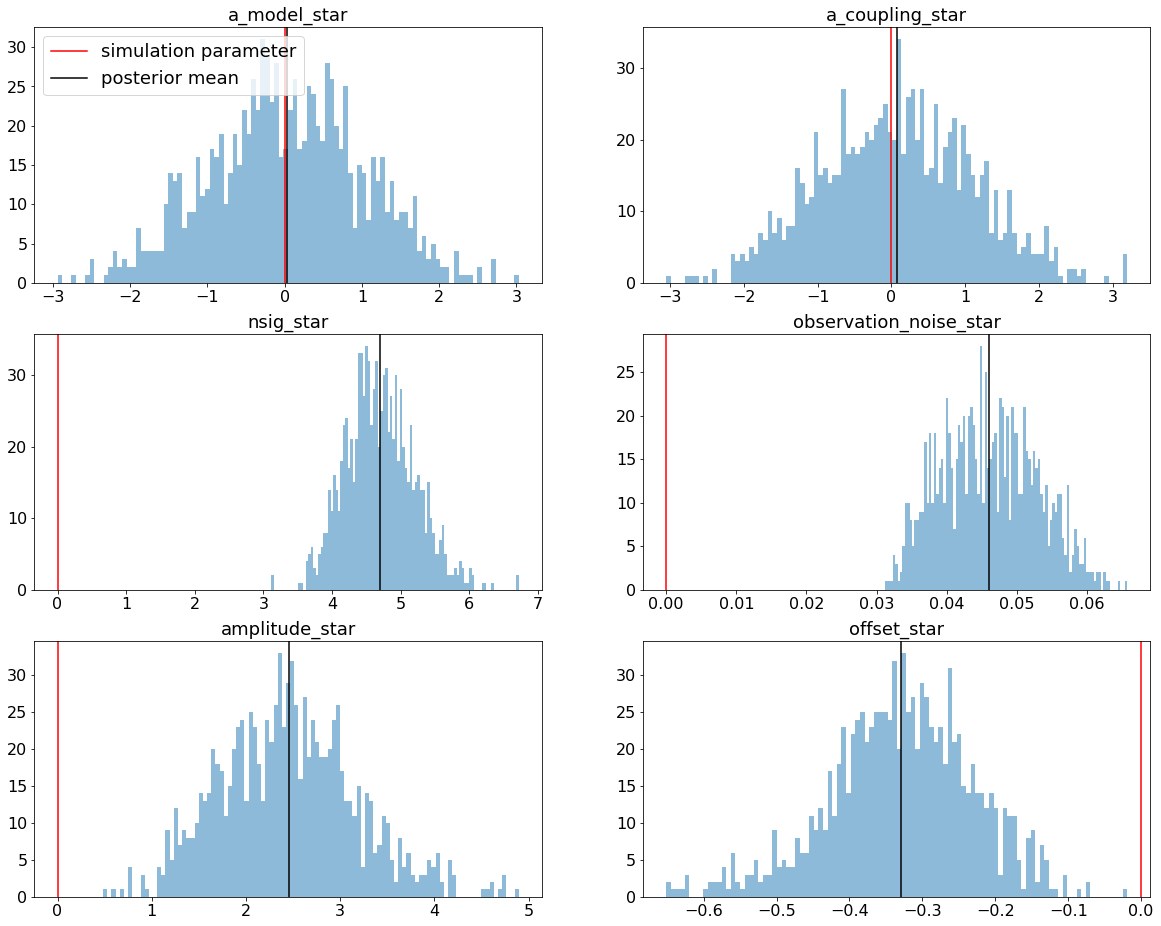

In [65]:
init_params = {
    "a_model_star": 0.0,
    "a_coupling_star": 0.0,
    "nsig_star": 0.0,
    "observation_noise_star": 0.0,
    "amplitude_star": 0.0,
    "offset_star": 0.0
}
plot_posterior_samples(pymc_estimator.inference_data,  init_params)

In [26]:
posterior_x_obs = pymc_estimator.inference_data.posterior_predictive.x_obs.values.reshape((cores*draws, *X.shape[:-1]))


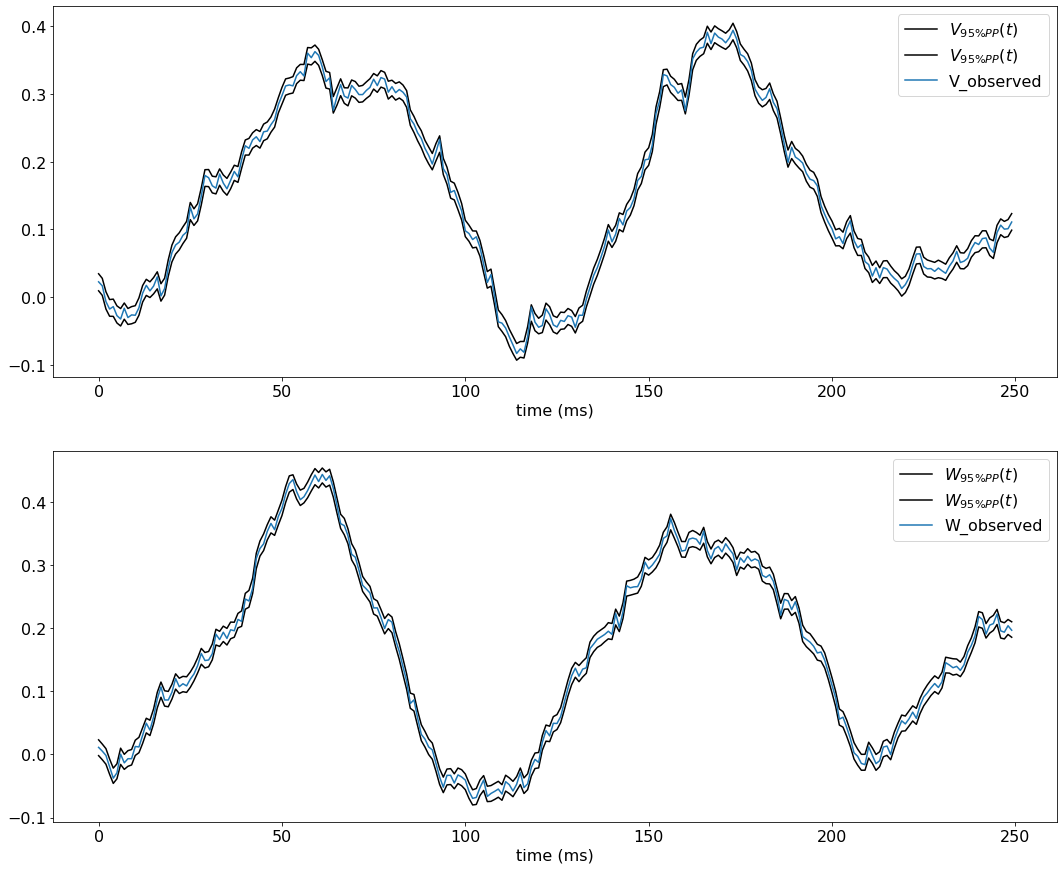

In [27]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [32]:
pymc_estimator.inference_summary.loc[['a_model_star', 'a_coupling_star', 'nsig_star', 
                                      'amplitude_star', 'offset_star', 'observation_noise_star']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_model_star,0.025,0.992,-1.773,1.880,0.041,0.029,585.0,693.0,1.00
a_coupling_star,0.074,1.033,-1.744,2.077,0.040,0.031,661.0,609.0,1.00
nsig_star,4.702,0.503,3.825,5.640,0.050,0.036,98.0,182.0,1.03
amplitude_star,2.452,0.719,1.128,3.755,0.114,0.097,51.0,110.0,1.05
offset_star,-0.329,0.099,-0.506,-0.131,0.012,0.010,69.0,79.0,1.03
observation_noise_star,0.046,0.007,0.034,0.058,0.002,0.001,15.0,45.0,1.13


In [58]:
pymc_estimator.inference_summary.loc[pymc_estimator.inference_summary.index.str.contains("x_init_star")].describe()
                                     
                                     

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,8.000000,8.000000,8.00000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.161375,0.561500,-0.91075,1.172500,0.025625,0.019000,374.625000,449.875000,1.012500
std,0.175102,0.471068,1.08119,0.692282,0.016647,0.012375,262.695335,213.300216,0.017525
min,-0.013000,0.116000,-2.27400,0.435000,0.009000,0.007000,103.000000,259.000000,1.000000
25%,0.006750,0.122750,-1.79175,0.546000,0.010000,0.007000,139.750000,278.500000,1.000000
50%,0.125500,0.552000,-0.89250,1.119500,0.025000,0.019000,318.000000,359.000000,1.000000
75%,0.303000,1.000000,0.07950,1.768500,0.039000,0.029500,629.000000,608.250000,1.030000
max,0.426000,1.025000,0.20000,2.012000,0.046000,0.033000,685.000000,801.000000,1.040000


In [60]:
pymc_estimator.inference_summary.loc[pymc_estimator.inference_summary.index.str.contains("dWt_star")].describe()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.015548,0.462691,-0.880427,0.845664,0.027665,0.019885,299.641000,416.513000,1.007300
std,0.911745,0.036532,0.911819,0.911443,0.005224,0.003807,71.352781,103.797127,0.007679
min,-2.918000,0.415000,-3.819000,-1.973000,0.019000,0.014000,77.000000,95.000000,1.000000
25%,-0.647500,0.449750,-1.496250,0.229750,0.024000,0.018000,257.000000,351.000000,1.000000
50%,0.000000,0.461000,-0.874000,0.867500,0.027000,0.019000,301.000000,418.500000,1.010000
75%,0.552000,0.471000,-0.303250,1.419000,0.029000,0.021000,349.000000,488.000000,1.010000
max,3.445000,1.001000,2.449000,4.197000,0.075000,0.053000,559.000000,724.000000,1.040000


In [ ]:
pymc_estimator.inference_data.to_netcdf(filename="pymc3_data/test1.nc", compress=False)